In [68]:
%matplotlib inline

In [69]:
import pandas as pd
import numpy as np  
import datetime 
import os,sys

train = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/com_train.csv', index_col=0)
# store = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/store.csv')
test = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/com_test.csv') 

# sys.path.append(os.path.abspath(os.path.join('/content/drive/MyDrive/Pharmaceutical_Sales_prediction')))
# # import sys
# from scripts.data_manipulation import DataManipulator


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Load the Data* and Make Transformations

In [74]:
scaler = MinMaxScaler()
# train = train[['date','Sales']]
train = train.loc[:,['Sales']]
new_train = train.iloc[:10000, :]
new_train

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2014-07-30,9674
2014-07-31,10907
2014-08-01,8908


In [75]:
scaler.fit(new_train.Sales.values.reshape([-1, 1]))
trainScaled = scaler.transform(new_train.Sales.values.reshape(-1, 1))
new_train['SalesScaled'] = trainScaled
new_train.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Sales,SalesScaled
Date,,
2014-07-25,5942,0.260363
2014-07-26,4782,0.209535
2014-07-27,0,0.000000
2014-07-28,8825,0.386688
2014-07-29,7874,0.345018
2014-07-30,9674,0.423889
2014-07-31,10907,0.477916
2014-08-01,8908,0.390325
2014-08-02,5969,0.261546


# Descriptive Statistics and Visualizations of the Data.


In [76]:
new_train.describe()

,Sales,SalesScaled
count,10000.000000,10000.000000
mean,5312.240600,0.232768
std,3264.453605,0.143040
min,0.000000,0.000000
25%,3755.000000,0.164534
50%,5397.000000,0.236482
75%,7355.000000,0.322277
max,22822.000000,1.000000


In [77]:
new_train = new_train[new_train['Sales'] != 0]  #Drops samples which have sales more than 25000
new_train.reset_index(drop=True)

,Sales,SalesScaled
0,5530,0.242310
1,4327,0.189598
2,4486,0.196565
3,4997,0.218955
4,7176,0.314433
...,...,...
8297,7874,0.345018
8298,9674,0.423889
8299,10907,0.477916
8300,8908,0.390325


In [78]:
new_train = new_train[new_train['Sales'] < 25000]  #Drops samples which have sales more than 25000
new_train.reset_index(drop=True)

,Sales,SalesScaled
0,5530,0.242310
1,4327,0.189598
2,4486,0.196565
3,4997,0.218955
4,7176,0.314433
...,...,...
8297,7874,0.345018
8298,9674,0.423889
8299,10907,0.477916
8300,8908,0.390325


In [79]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

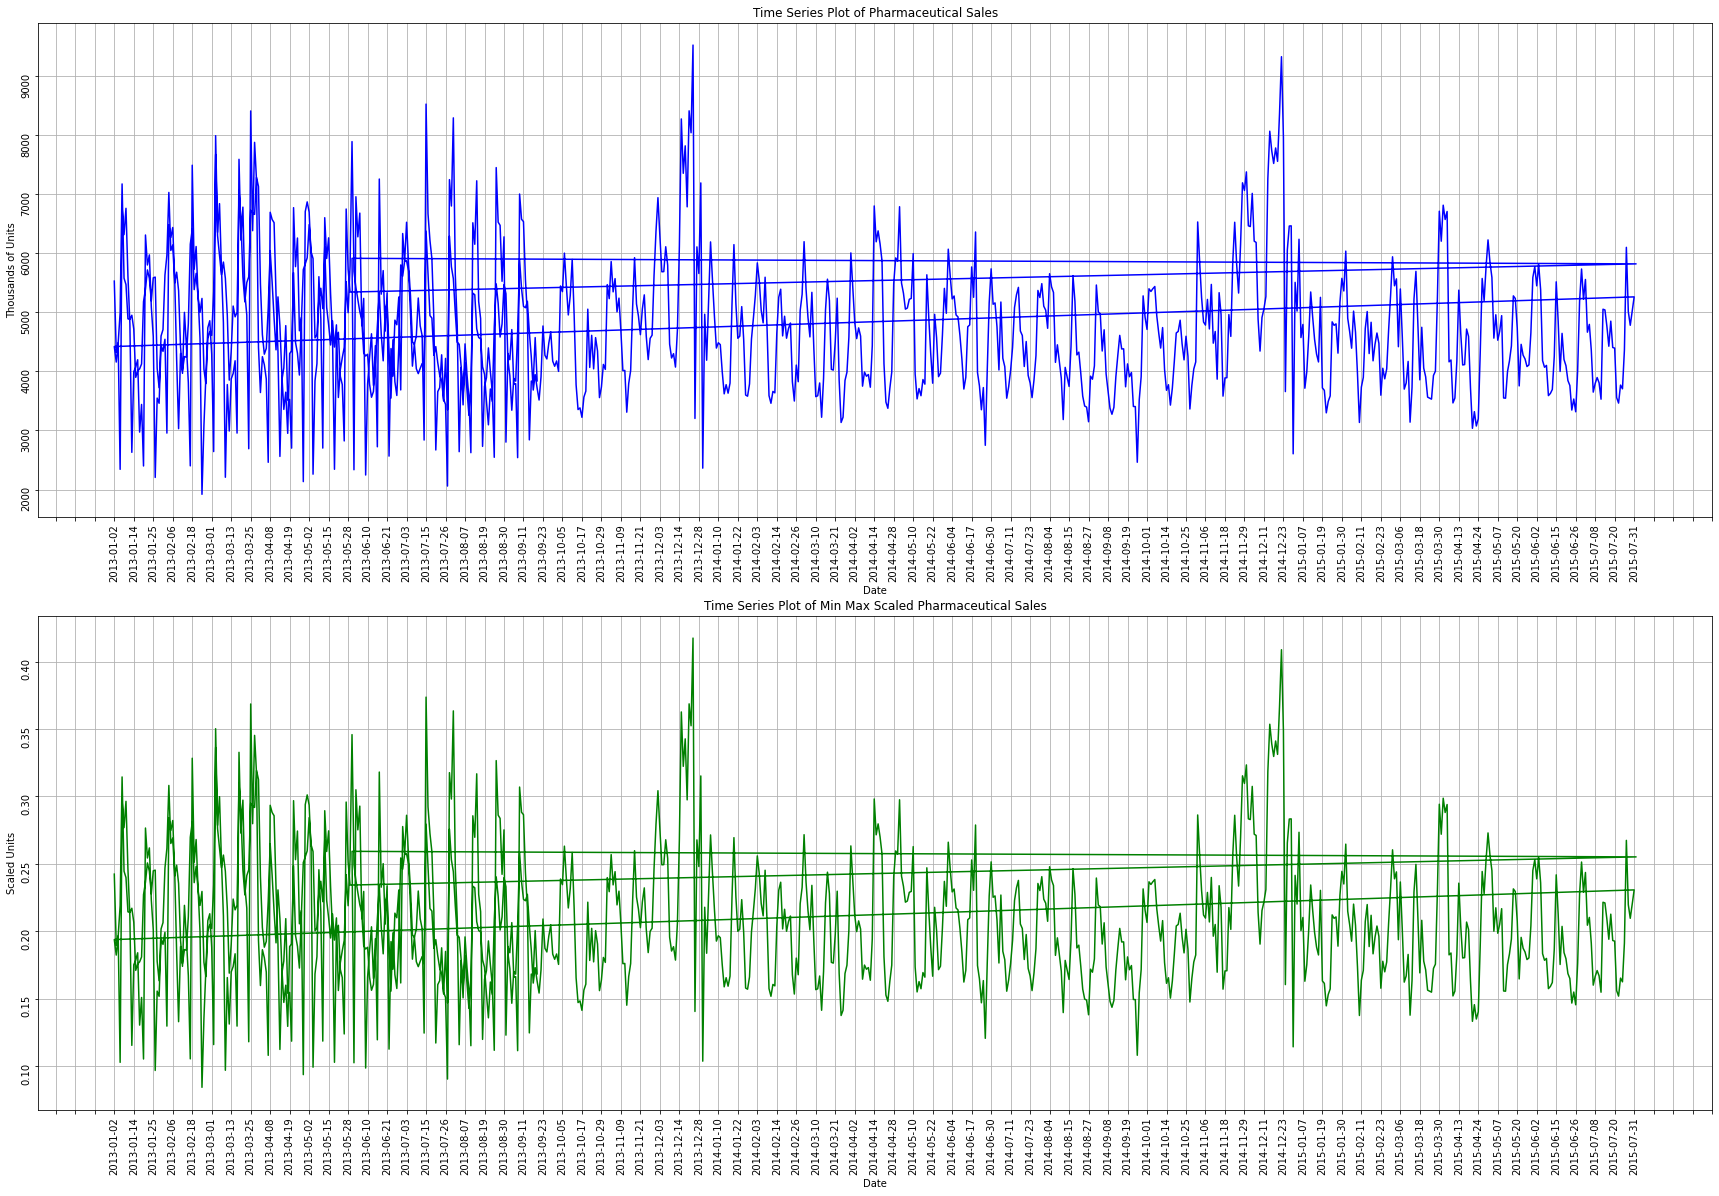

In [80]:
new_train = new_train.iloc[:1000,:]
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(new_train.index, new_train.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(new_train.index, new_train.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

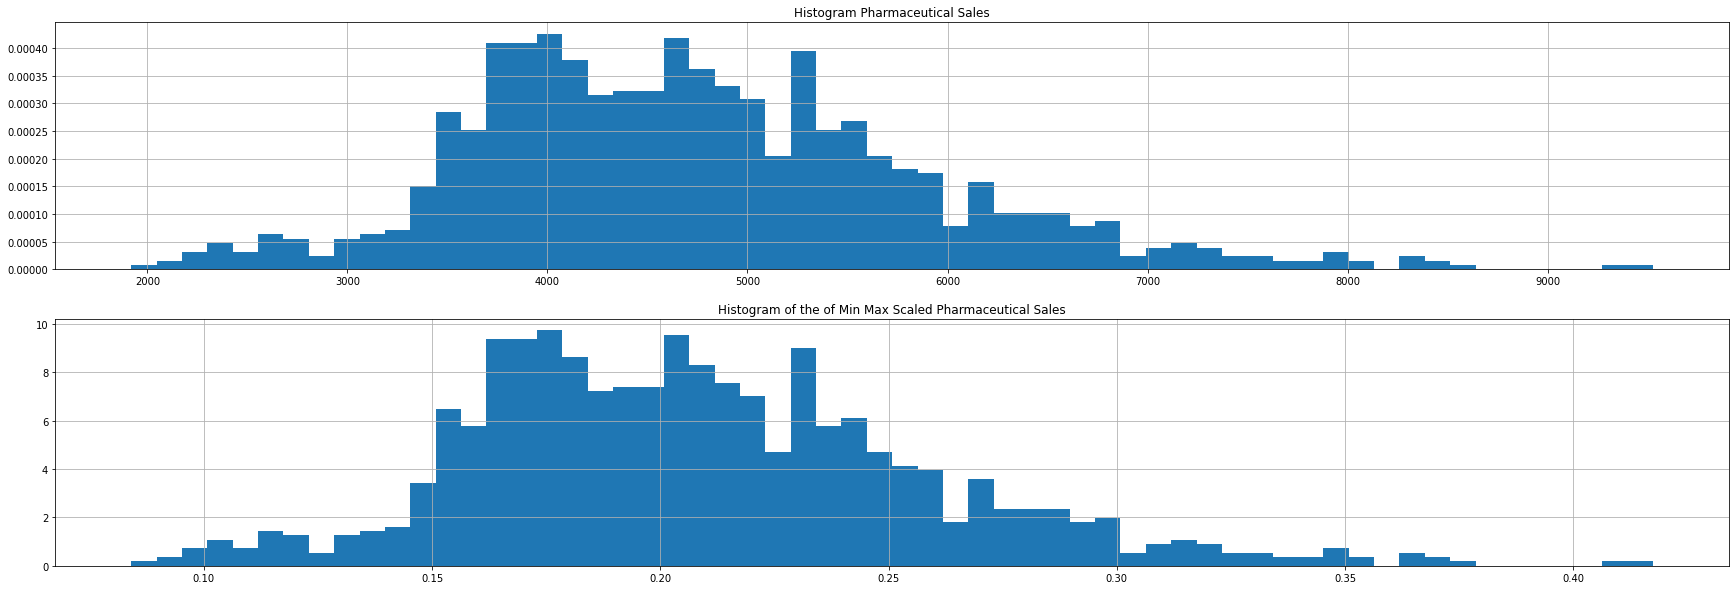

In [81]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(new_train.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Pharmaceutical Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(new_train.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Pharmaceutical Sales')
ax2.grid(True)
plt.show()

# Unit Root Tests.

In [82]:
trains = train.loc[:,['Sales']]
trains = trains.iloc[:10000, :]
trains

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2014-07-30,9674
2014-07-31,10907
2014-08-01,8908


In [83]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
adfResult = adfuller(new_train.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -6.205830865776792
p-value: 5.661051471529297e-08


In [84]:
adfResult = adfuller(new_train.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -6.205830865776784
p-value: 5.6610514715295674e-08


# Removing Stationarity

In [85]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [86]:
new_trainDif = difference(new_train.SalesScaled.values)

In [87]:
new_trainDif

0     -0.052712
1      0.006967
2      0.022391
3      0.095478
4     -0.069933
         ...   
994   -0.092586
995    0.043642
996   -0.000613
997    0.032907
998   -0.032162
Length: 999, dtype: float64

# Autocorrelations and Partial Autocorrelations Plots.

In [88]:
acfSalesScaled = acf(new_train.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [89]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

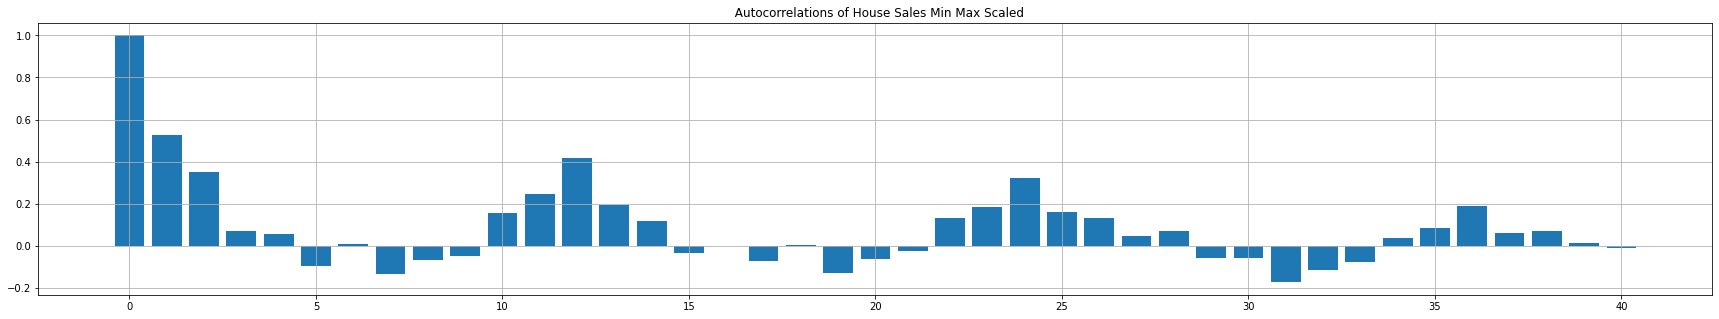

In [90]:
corrPlots(acfSalesScaledNp, '')

In [91]:
pacfSalesScaled = pacf(new_train.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

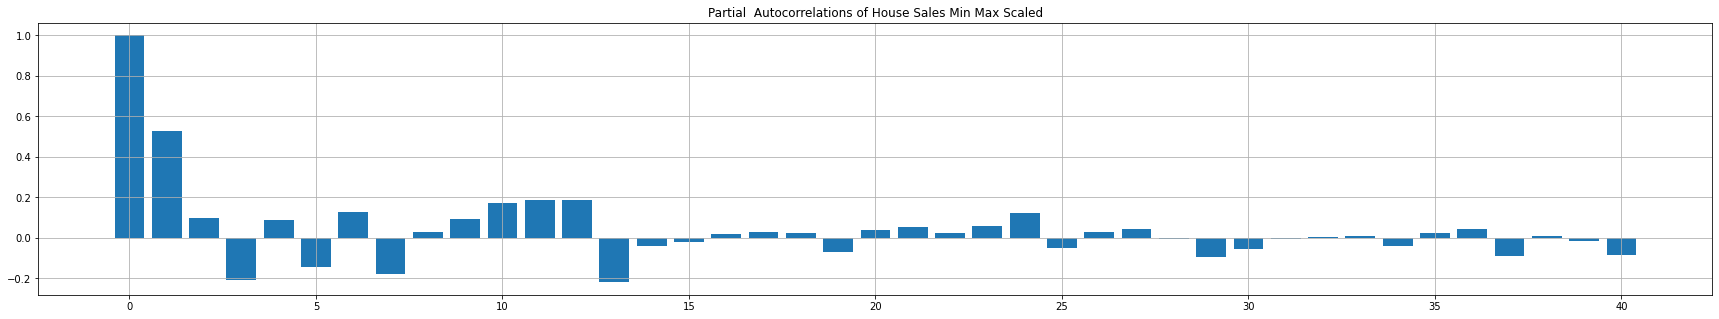

In [92]:
corrPlots(pacfSalesScaledNp, "Partial")

# Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [93]:
SIZE = len(new_train.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [94]:
DateTrain = new_train.index.values[0:BATCH_SIZE]
DateValid = new_train.index.values[BATCH_SIZE:]
XTrain = new_train.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = new_train.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (904, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (904,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [95]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([904, 1])

In [96]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [97]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [98]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [99]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [100]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [101]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [102]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [103]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

# Define and Estimate the LSTM.

In [104]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 8)           320       
                                                                 
 lstm_3 (LSTM)               (None, 4)                 208       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0378 - val_loss: 0.0360
Epoch 2/200
1/1 [==============================] - 0s 226ms/step - loss: 0.0357 - val_loss: 0.0340
Epoch 3/200
1/1 [==============================] - 0s 211ms/step - loss: 0.0337 - val_loss: 0.0320
Epoch 4/200
1/1 [==============================] - 0s 234ms/step - loss: 0.0317 - val_loss: 0.0302
Epoch 5/200
1/1 [==============================] - 0s 230ms/step - loss: 0.0298 - val_loss: 0.0284
Epoch 6/200
1/1 [==============================] - 0s 217ms/step - loss: 0.0280 - val_loss: 0.0267
Epoch 7/200
1/1 [==============================] - 0s 241ms/step - loss: 0.0263 - val_loss: 0.0251
Epoch 8/200
1/1 [==============================] - 0s 445ms/step - loss: 0.0247 - val_loss: 0.0236
Epoch 9/200
1/1 [==============================] - 0s 451ms/step - loss: 0.0231 - val_loss: 0.0221
Epoch 10/200
1/1 [==============================] - 0s 415ms/step - loss: 0.0216 - val_loss: 0.0206
Epoch 11/200

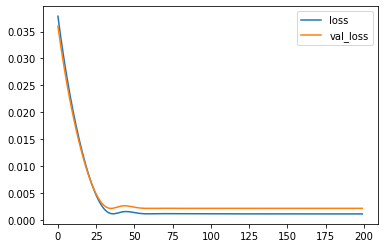

In [107]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Forecast the LSTM on the Validation Set and Assess Accuracy.

In [108]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [109]:
Forecast = model_forecast(model, new_train.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

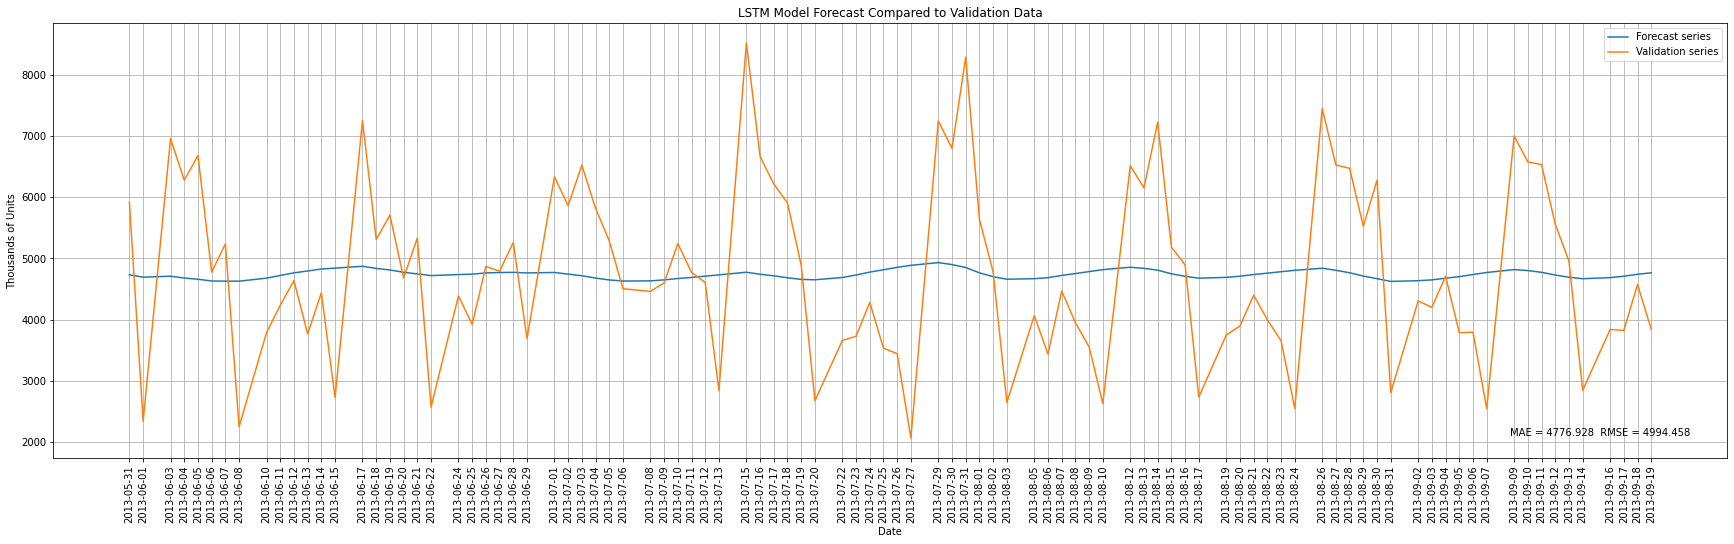

In [110]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [111]:
print(textstr)

MAE = 4776.928  RMSE = 4994.458


In [112]:
import pickle

In [158]:
with open('istm_model.plk', 'wb') as f:
  pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://df14eae3-5687-4f86-ab12-b9998e620507/assets


INFO:tensorflow:Assets written to: ram://df14eae3-5687-4f86-ab12-b9998e620507/assets


In [159]:
with open('istm_model.plk', 'rb') as f:
  mp = pickle.load(f)

In [ ]:
mp.predict(new_train)

### Time Series Analysis and Forecasts with Prophet

In [124]:

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
# prophet by Facebook
from fbprophet import Prophet

In [149]:
traindf = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/train_final.csv', index_col=0)
# traindf

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### ECDF: empirical cumulative distribution function

In [150]:
traindf['SalePerCustomer'] = traindf['Sales']/traindf['Customers']

Text(0.5, 0, 'Sale per Customer')

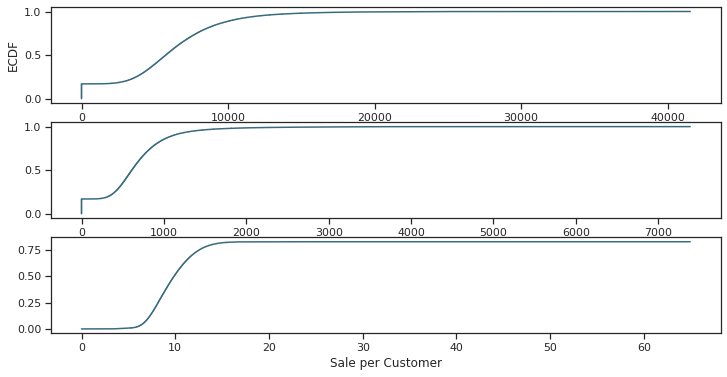

In [151]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(traindf['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(traindf['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(traindf['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer')

In [152]:
# opened stores with zero sales
zero_sales = traindf[(traindf.Open != 0) & (traindf.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 19)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
86825,971,5,2015-05-15,0,0,1,0,0,1,c,a,1140.0,5.0,2011.0,1,14.0,2012.0,"Mar,Jun,Sept,Dec",NaN
142278,674,4,2015-03-26,0,0,1,0,0,0,a,a,2640.0,12.0,2005.0,1,31.0,2013.0,"Feb,May,Aug,Nov",NaN
196938,699,4,2015-02-05,0,0,1,1,0,0,a,a,180.0,0.0,0.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",NaN
322053,708,3,2014-10-01,0,0,1,1,0,0,c,c,11470.0,10.0,2009.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",NaN
330176,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.0,10.0,2008.0,0,0.0,0.0,0,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


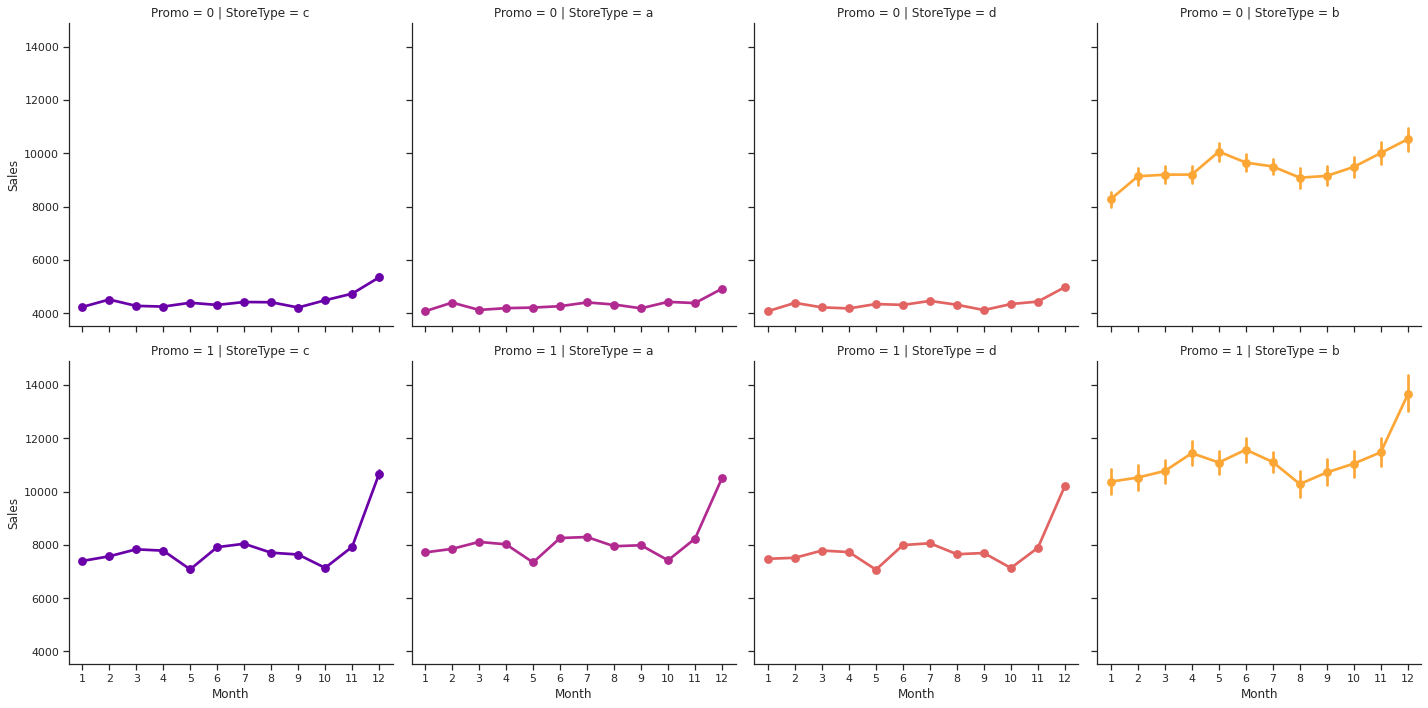

In [131]:
sns.factorplot(data = traindf, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


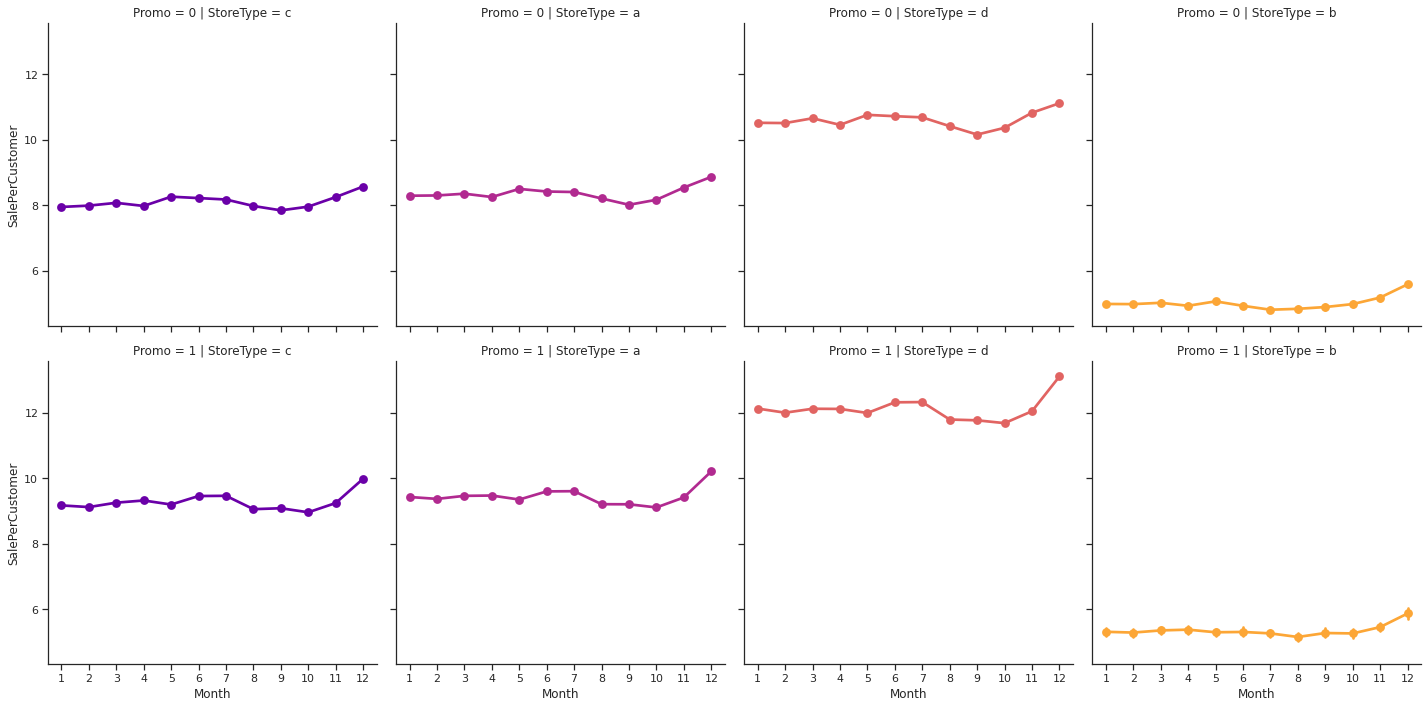

In [132]:
# sale per customer trends
sns.factorplot(data = traindf, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

In [153]:
# remove closed stores and those with no sales
df = traindf[(traindf["Open"] != 0) & (traindf['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = traindf[traindf.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [155]:
# create holidays dataframe
state_dates = traindf[(traindf.StateHoliday == 'a') | (traindf.StateHoliday == 'b') & (traindf.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = traindf[traindf.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04
